In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) 

Mounted at /content/drive


In [ ]:
!pip install focal-loss

In [ ]:
cd /content/drive/MyDrive/Classes/images

/content/drive/MyDrive/Classes/images


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from focal_loss import sparse_categorical_focal_loss, SparseCategoricalFocalLoss
import matplotlib.pyplot as plt  
import numpy as np

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision 
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [ ]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = "/content/drive/MyDrive/Resnet18/train"
valid_data_dir = "/content/drive/MyDrive/Resnet18/val"
test_data_dir  = "/content/drive/MyDrive/Resnet18/test"

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data


valid_generator = test_datagen.flow_from_directory(
    valid_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 22690 images belonging to 3 classes.
Found 2835 images belonging to 3 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical'
  ) # set as test data

Found 2839 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
len(y)

1

In [ ]:
train_generator.num_classes

3

In [ ]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2, alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Classes/Data/Polyp13.h5", monitor= 'accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions) 
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])


94781440/94765736 [==============================] - 1s 0us/step
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [ ]:
model.fit(train_generator,validation_data=valid_generator,epochs = 160,callbacks=[es,checkpoint])

Epoch 1/160
710/710 [==============================] - 7361s 10s/step - loss: 0.9811 - accuracy: 0.5373 - val_loss: 0.9245 - val_accuracy: 0.5527

Epoch 00001: accuracy improved from -inf to 0.53729, saving model to /content/drive/MyDrive/Classes/Data/Polyp13.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/160
710/710 [==============================] - 380s 535ms/step - loss: 0.9327 - accuracy: 0.5545 - val_loss: 0.9048 - val_accuracy: 0.5443

Epoch 00002: accuracy improved from 0.53729 to 0.55452, saving model to /content/drive/MyDrive/Classes/Data/Polyp13.h5
Epoch 3/160
710/710 [==============================] - 379s 533ms/step - loss: 0.9150 - accuracy: 0.5605 - val_loss: 0.9299 - val_accuracy: 0.5534

Epoch 00003: accuracy improved from 0.55452 to 0.56051, saving model to /content/drive/MyDrive/Classes/Data/Polyp13.h5
Epoch 4/160
710/710 [==============================] - 379s 534ms/step - loss: 0.8837 - accuracy: 0.5703 - val_loss: 0.8532 - val_accuracy: 0.6081

Epoch 00004: accuracy improved from 0.56051 to 0.57030, saving model to /content/drive/MyDrive/Classes/Data/Polyp13.h5
Epoch 5/160
710/710 [==============================] - 377s 530ms/step - loss: 0.8570 - accuracy: 0.5924 - val_loss: 0.8245 - val_accuracy: 0.6134

Epoch 00005: accuracy improved from 0.57030 to 0.59

In [ ]:
model.save('/content/drive/MyDrive/Classes/Data/Polyp13.h5' )

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


89/89 - 21s - loss: 0.5855 - accuracy: 0.7499

Test accuracy: 0.7499118447303772


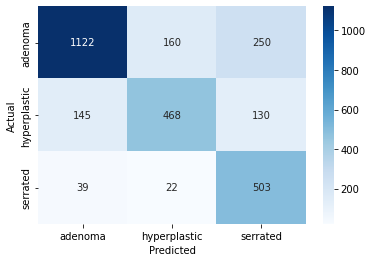

test accuracy : 73.72314195139134


In [ ]:
test_loss, test_acc = model.evaluate(valid_generator, verbose=2)
print('\nTest accuracy:', test_acc)
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/Classes/Data/Polyp13.h5",compile=False)
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show() 
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100))) 